# Citizen weather stations data

In this notebook, we will assemble a time series of meteorological measurements from the citizen weather stations (CWS) in the study region for the heatwave period determined using the official weather stations data.

In [ ]:
import os

import contextily as cx
import geopandas as gpd
import pandas as pd
import seaborn as sns
from meteostations.clients import netatmo

NETATMO_SCALE = "1hour"  # could also be "30min"

/home/martibosch/mambaforge/envs/uhi-drivers-lausanne/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# spatial extent
agglom_extent_filepath = "../data/raw/agglom-extent.gpkg"

# official station data just to get the time range
official_ts_df_filepath = "../data/interim/official-ts-df.csv"

# we need to dump both the time series of measurements and the stations' locations
dst_ts_df_filepath = "../data/raw/cws-ts-df.csv"
dst_stations_gdf_filepath = "../data/raw/cws-stations.gpkg"

In [ ]:
# heatwave start and end
heatwave_start, heatwave_end = pd.to_datetime(
    pd.read_csv(official_ts_df_filepath, index_col=0).index.to_series()
).agg(["min", "max"])

In [ ]:
# select only land extent (agglom_extent_filepath has two geometries: land and lake)
region = gpd.read_file(agglom_extent_filepath)["geometry"].iloc[:1]

# this will open a browser window to authorize the OAuth2 connection
client = netatmo.NetatmoClient(
    region=region,
    client_id=os.environ["NETATMO_CLIENT_ID"],
    client_secret=os.environ["NETATMO_CLIENT_SECRET"],
)

100%|█████████████████████████████████████████████████| 3/3 [00:00<00:00, 5971.96it/s]
Gtk-Message: 15:03:12.435: Failed to load module "canberra-gtk-module"
Gtk-Message: 15:03:12.436: Failed to load module "canberra-gtk-module"


Opening in existing browser session.
Enter authorization code: 624dd71becfd2a5ceafec4f34dae4b18


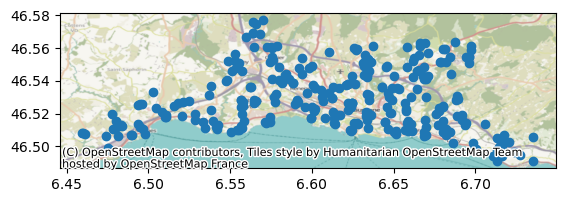

In [ ]:
ax = client.stations_gdf.plot()
cx.add_basemap(ax, crs=client.stations_gdf.crs)

In [ ]:
cws_ts_df = client.get_ts_df(
    variables="temperature",
    start_date=heatwave_start,
    end_date=heatwave_end,
    scale=NETATMO_SCALE,
)

 55%|█████████████████████████▊                     | 158/287 [00:02<00:01, 67.96it/s]

{'code': 9, 'message': 'Device not found'}


100%|██████████████████████████████████████████████| 287/287 [00:02<00:00, 102.45it/s]


<Axes: xlabel='time', ylabel='value'>

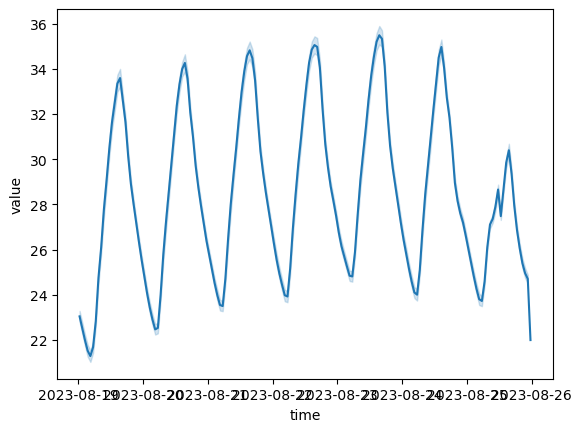

In [ ]:
sns.lineplot(data=cws_ts_df, x="time", y="value")

In [ ]:
# dump filtered data
cws_ts_df.to_csv(dst_ts_df_filepath, index=False)
client.stations_gdf.to_file(dst_stations_gdf_filepath)